<div align="center"><h1>
FYS-STK4155 - Project 1 Notebook
</div>
<div align="center"><h2>
Håvard Skåli, Erik Røset and Oskar Idland
</div>
<hr style="border:2px solid gray"> </hr>
<div align="center"><h3>
Part 2: Analysis of Cosmological Simulation Data
</div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from functions import *
plt.rcParams.update({'text.usetex': True, 'font.size': 16, 'font.family': 'serif', 'font.serif': 'Computer Modern Sans Serif', 'font.weight': 100, 'mathtext.fontset': 'cm', 'xtick.labelsize': 14, 'ytick.labelsize': 14})

seed = 43
np.random.seed(seed)

### Importing the data

#### Dark matter simulation data at redshift $z\approx12.88$

In [3]:
with open("../data/darkmatter_1288.txt", "r") as infile:
    params = infile.readline().split(",")
    # The box unit, density unit, dimensionless Hubble constant, x and y are the same for both redshifts
    box_unit, rho_unit, h, a_1288 = params[0].split(": ")[1], params[1].split(": ")[1], float(params[2].split(": ")[1]), float(params[3].split(": ")[1]) 
    y = np.array(infile.readline().split(), dtype = float)
    x = []; rho_1288 = []
    for line in infile:
        vals = line.split()
        x.append(float(vals[-1]))
        rho_1288.append(np.array(vals[:-1], dtype = float))
x = np.array(x); rho = np.array(rho_1288)

#### Dark matter simulation data at redshift $z=0$

In [4]:
# The box unit, density unit, dimensionless Hubble constant, x and y are the same for both redshifts, so we only store the values of a and ρ this time

with open("../data/darkmatter_0.txt", "r") as infile:
    params = infile.readline().split(",")
    a_0 = float(params[3].split(": ")[1]) 
    infile.readline()
    rho_0 = []
    for line in infile:
        vals = line.split()
        rho_0.append(np.array(vals[:-1], dtype = float))
rho = np.array(rho_0)

### Visualizing the data

#### Using imshow

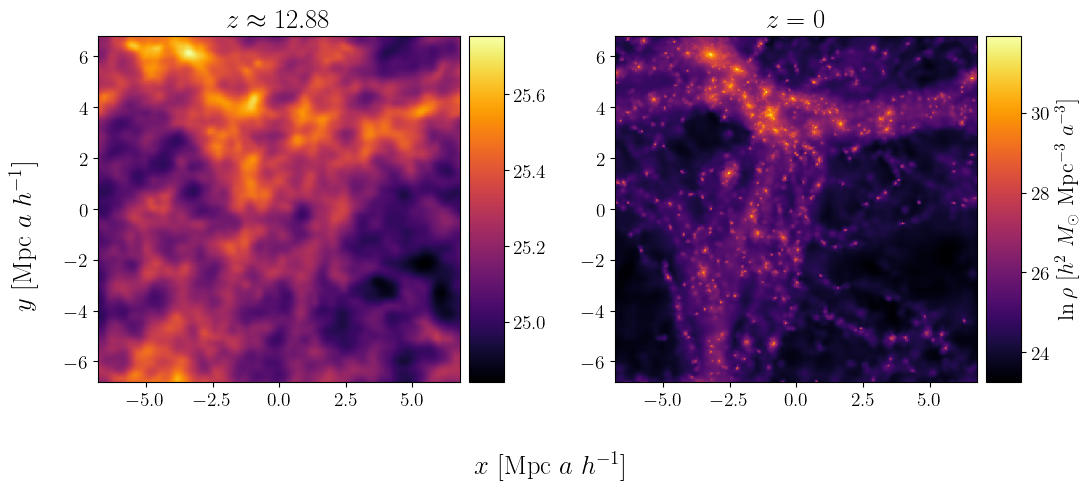

In [11]:
xx, yy = np.meshgrid(x, y)

fig, axs = plt.subplots(1, 2, figsize = (11.25, 5))
im_1288 = axs[0].imshow(np.log(rho_1288[::-1]), cmap = "inferno", aspect = "auto", interpolation = "nearest", extent = [np.min(x), np.max(x), np.min(y), np.max(y)])
im_0 = axs[1].imshow(np.log(rho_0[::-1]), cmap = "inferno", aspect = "auto", interpolation = "nearest", extent = [np.min(x), np.max(x), np.min(y), np.max(y)])

plt.colorbar(im_1288, ax = axs[0], pad = 0.02, aspect = 10)
plt.colorbar(im_0, ax = axs[1], label = r"$\ln\rho$ [" + rho_unit + "]", pad = 0.02, aspect = 10)

axs[0].set_title(r"$z\approx12.88$")
axs[1].set_title(r"$z=0$")

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")

plt.tight_layout()
plt.savefig("../figs/density.pdf")
plt.show()

#### Using surface plots

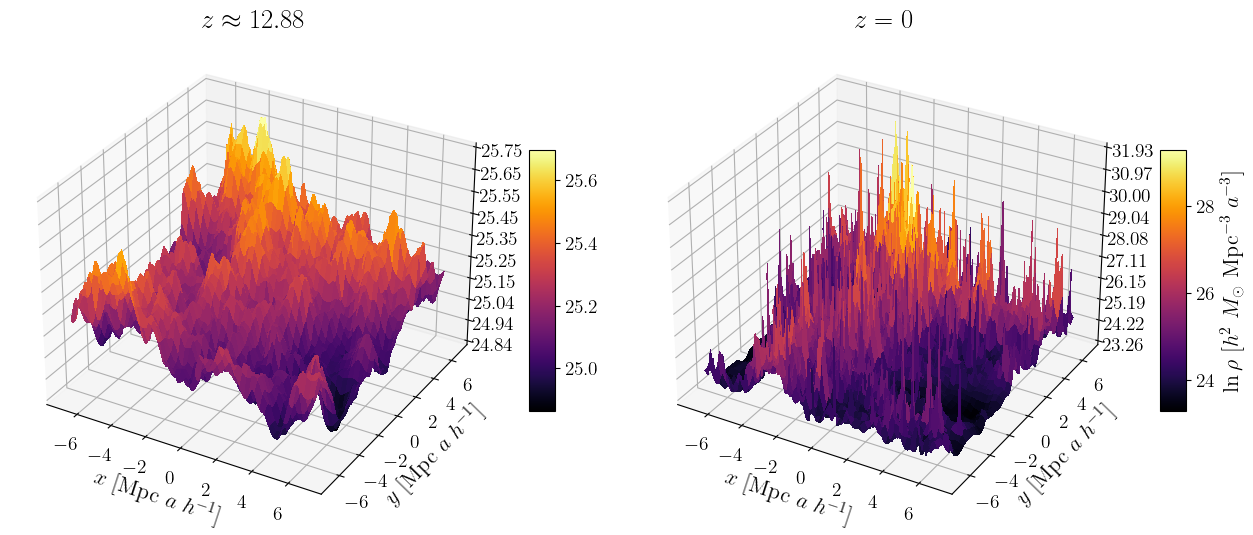

In [12]:
fig = plt.figure(figsize = (13, 7))
axs = [fig.add_subplot(121, projection = "3d"), fig.add_subplot(122, projection = "3d")]

surf_1288 = axs[0].plot_surface(xx, yy, np.log(rho_1288), cmap = "inferno", linewidth = 0, antialiased = False)
surf_0 = axs[1].plot_surface(xx, yy, np.log(rho_0), cmap = "inferno", linewidth = 0, antialiased = False)

fig.colorbar(surf_1288, shrink = 0.4, aspect = 10)
fig.colorbar(surf_0, shrink = 0.4, aspect = 10, label = r"$\ln\rho$ [" + rho_unit + "]")

titles = [r"$z\approx12.88$", r"$z=0$"]
for i in range(2):
    axs[i].zaxis.set_major_locator(LinearLocator(10))
    axs[i].zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    axs[i].set_xlabel(r"$x$ [" + box_unit + "]")
    axs[i].set_ylabel(r"$y$ [" + box_unit + "]")
    axs[i].set_title(titles[i])
    
plt.tight_layout()
plt.savefig("../figs/density_surf.pdf")
plt.show()

### OLS: MSE and $R^2$ as function of polynomial degree for scaled and raw data

In [35]:
x.reshape(-1, 1); y.reshape(-1, 1) 
z_1288 = np.log(rho_1288).reshape(-1, 1) 
z_0 = np.log(rho_0).reshape(-1, 1) 

MSE_raw_list = []
MSE_scaled_list = []
R2_raw_list = []
R2_scaled_list = []
β_raw_list = []
β_scaled_list = []

degrees = range(1, 7)
z_list = [z_1288, z_0]
for z in z_list:
    MSE_raw_list.append([])
    MSE_scaled_list.append([])
    R2_raw_list.append([])
    R2_scaled_list.append([])
    β_raw_list.append([])
    β_scaled_list.append([])
    for degree in degrees:
        # Raw
        MSE_raw, R2_raw, β_raw = OLS(x, y, z, degree, scale = False, seed = seed, intercept = True, return_beta = True)
        
        MSE_raw_list[-1].append(MSE_raw)
        R2_raw_list[-1].append(R2_raw)
        β_raw_list[-1].append(β_raw)
        
        # Scaled
        MSE_scaled, R2_scaled, β_scaled = OLS(x, y, z, degree, seed = seed, return_beta = True)
        
        MSE_scaled_list[-1].append(MSE_scaled)
        R2_scaled_list[-1].append(R2_scaled)
        β_scaled_list[-1].append(β_scaled)

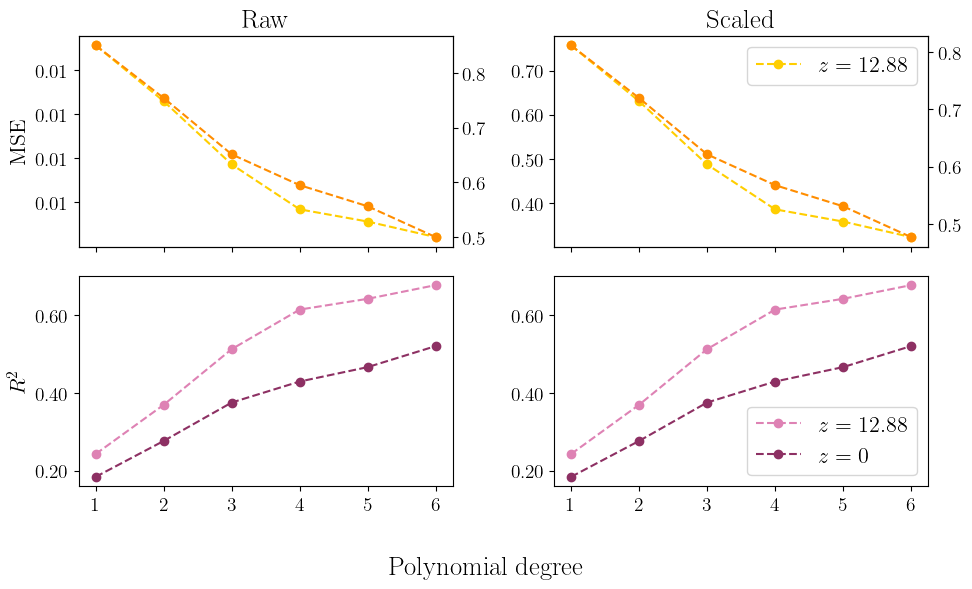

In [38]:
colors = [["#ffce00", "#ff8d00"], ["#de82b4", "#8d3063"]]
titles = ["Raw", "Scaled"]
ylabels = ["MSE", r"$R^2$"]
values = np.array([[MSE_raw_list, MSE_scaled_list], [R2_raw_list, R2_scaled_list]])

# Plotting in grid
fig, axs = plt.subplots(2, 2, sharex = True, figsize = (10, 6))
for i in range(2):
    axs[i, 0].set_ylabel(ylabels[i])
    for j in range(2):
        axs[i, j].plot(degrees, values[i, j][0], "--o", color = colors[i][0], label = r"$z=12.88$")
        if i == 0:
            ax_2 = axs[i, j].twinx()
            ax_2.plot(degrees, values[i, j][1], "--o", color = colors[i][1], label = r"$z=0$")
        else:
            axs[i, j].plot(degrees, values[i, j][1], "--o", color = colors[i][1], label = r"$z=0$")
        if i == 0:
            axs[i, j].set_title(titles[j])
        axs[i, j].yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    axs[i, 1].legend()
fig.supxlabel('Polynomial degree')
plt.tight_layout()
plt.savefig("../figs/g_error_scaled_vs_raw.pdf")
plt.show()

In [ ]:
#TODO plot for higher complexities?

#### Comment for the report:

1. Scaling seems to work as it should here as well. Because the $z=12.88$ and $z=0$ datasets are vastly different their raw MSE values will differ in magnitude as well, so it is not as easy to see that the MSE has been scaled by a constant factor in both cases, unless we have two $y$-axes for each of the upper plots. Then the left $y$-axes correspond to $z=12.88$ while the right correspond to $z=0$.
2. The MSE and $R^2$ scores are generally higher and lower, respectively, for the $z=0$ dataset. This makes sense since this dataset has a much more complex structure, hence we need much higher polynomial degrees to get a good fit.

### OLS: Exploring how the fits depend on complexity 

In [44]:
z_list = [z_1288, z_0]
degrees = [5, 10, 20, 30, 50]
z_fits = []
for z in z_list:
    z_fits.append([])
    for degree in degrees:
        MSE_score, R2_score, β, X, scaler_X, scaler_z = OLS(x, y, z, degree, seed = seed, return_beta = True, return_X = True, return_scalers = True)
        z_fits[-1].append(scaler_z.inverse_transform(scaler_X.transform(X) @ β).reshape((len(x), len(y))))

#### Plotting for $z=12.88$ with imshow

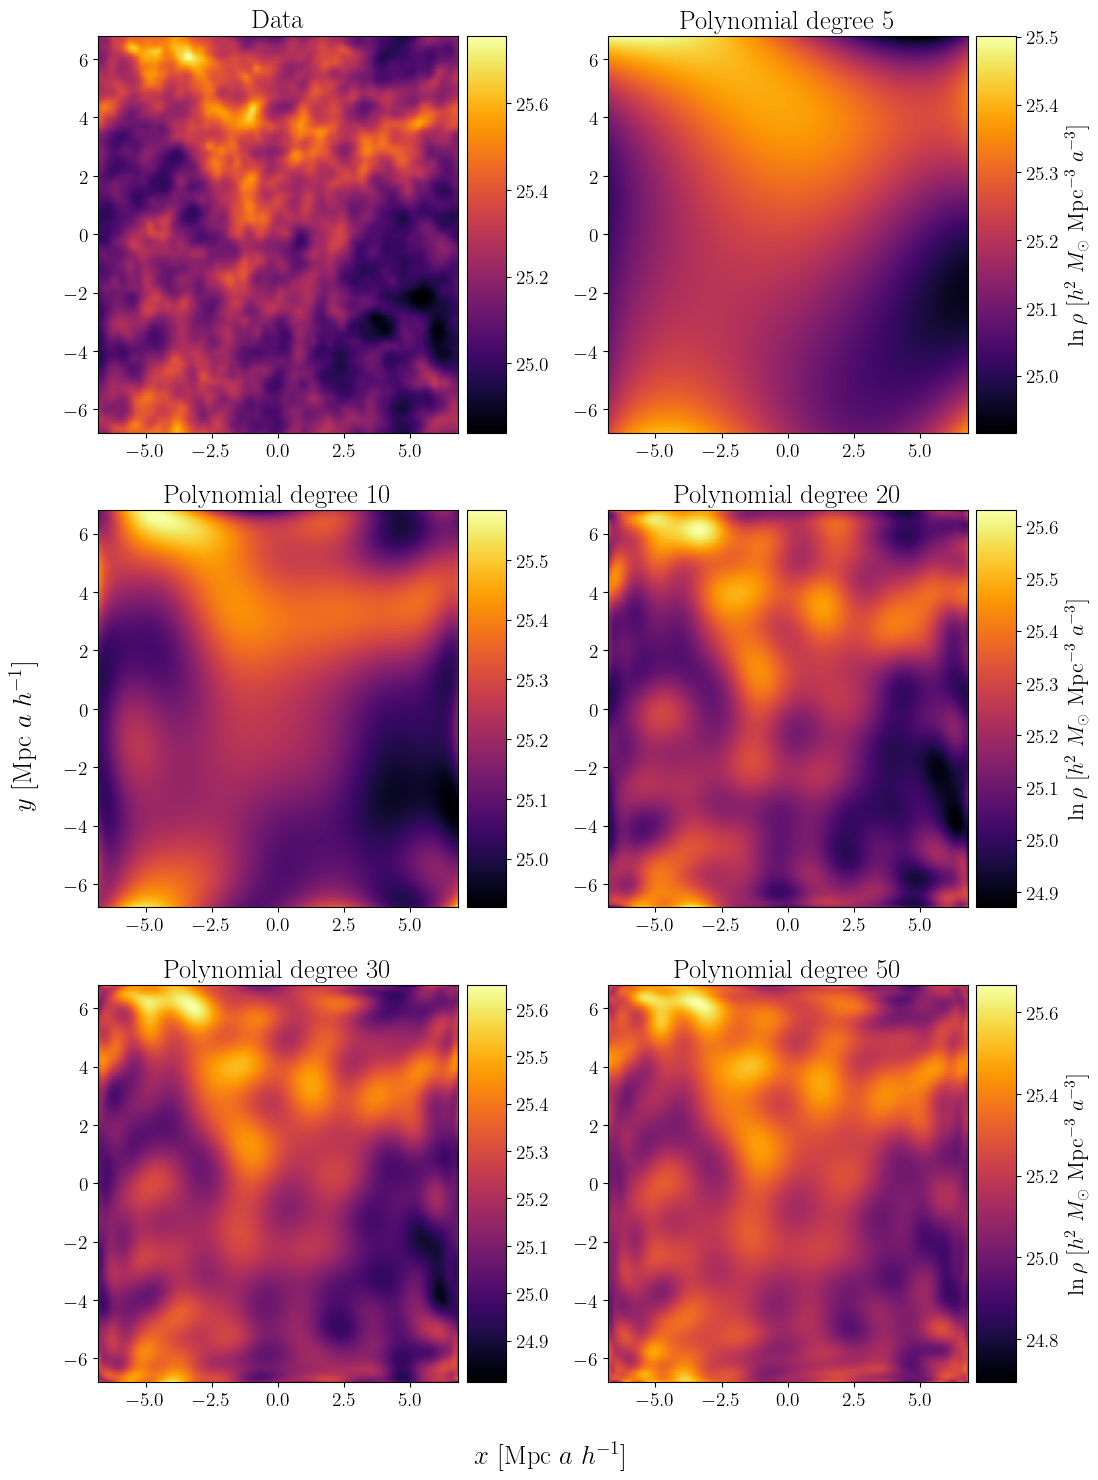

In [45]:
fig, axs = plt.subplots(3, 2, figsize = (11.25, 15))

im = []
idx = 0
for i in range(3):
    for j in range(2):
        if i == 0 and j == 0:
            im.append(axs[i, j].imshow(np.log(rho_1288[::-1]), cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title("Data")
        else:
            im.append(axs[i, j].imshow(z_fits[0][idx][::-1], cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title(f"Polynomial degree {degrees[idx]}")
            idx += 1
        plt.colorbar(im[-1], ax = axs[i, j], label = r"$\ln\rho$ [" + rho_unit + "]" if j == 1 else None, pad = 0.02, aspect = 10)

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")
plt.tight_layout()
plt.savefig("../figs/density_1288_complexity.pdf")
plt.show()

#### Plotting for $z=0$ with imshow

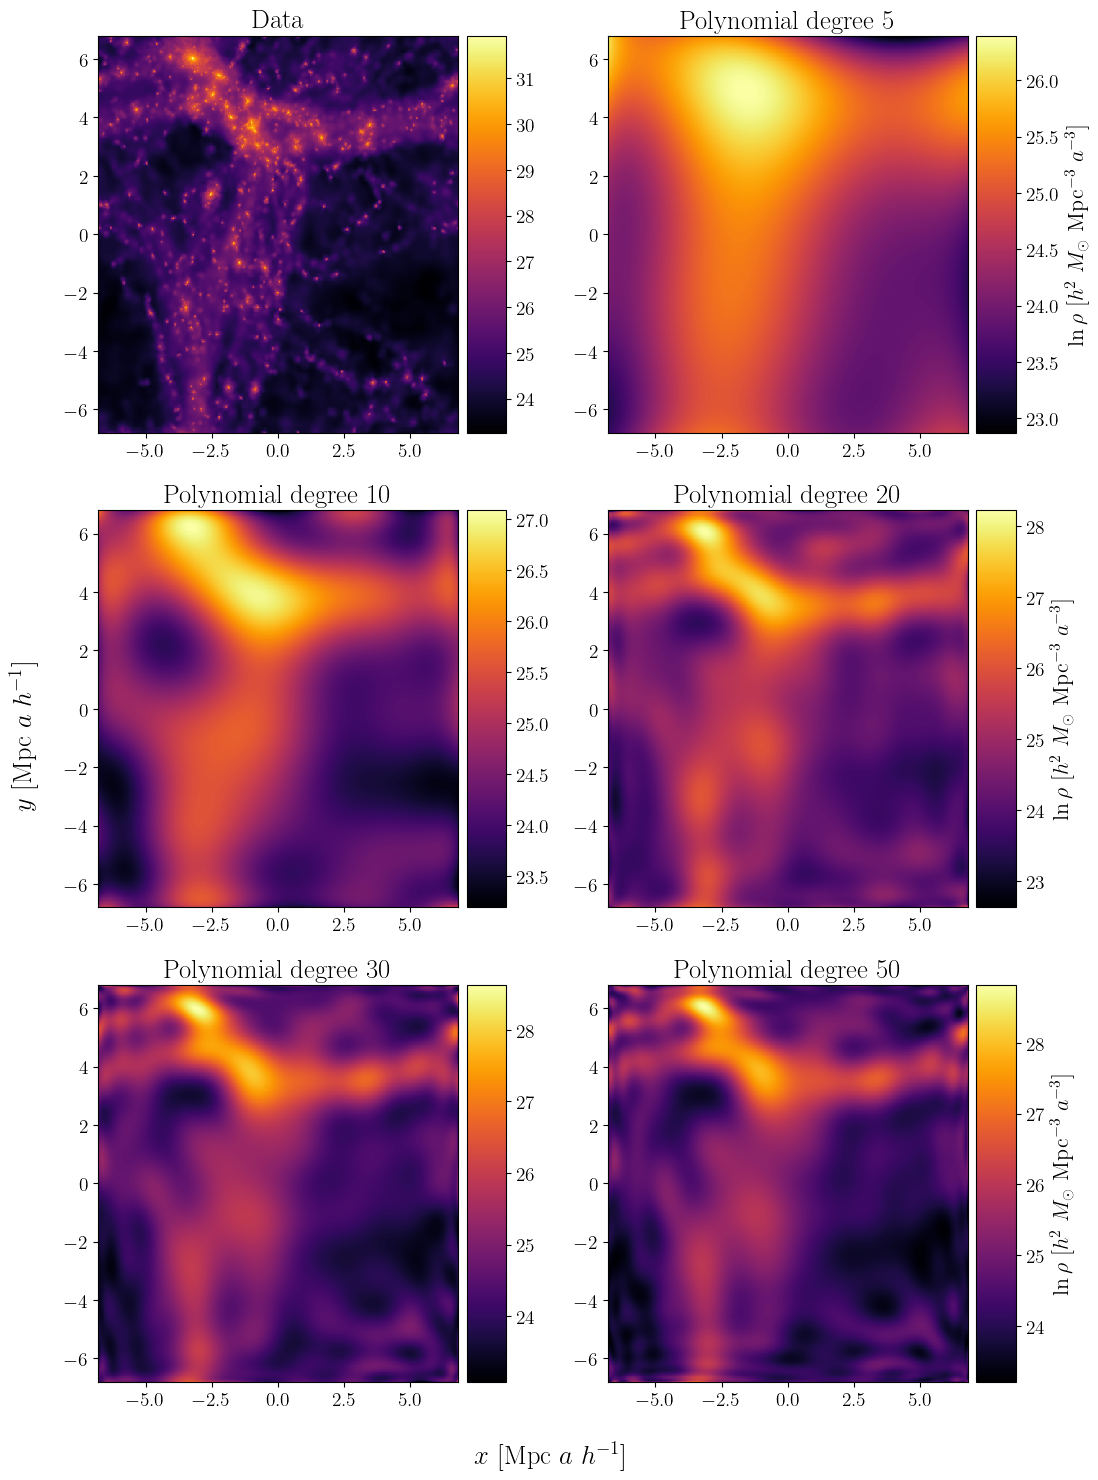

In [46]:
fig, axs = plt.subplots(3, 2, figsize = (11.25, 15))

im = []
idx = 0
for i in range(3):
    for j in range(2):
        if i == 0 and j == 0:
            im.append(axs[i, j].imshow(np.log(rho_0[::-1]), cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title("Data")
        else:
            im.append(axs[i, j].imshow(z_fits[1][idx][::-1], cmap = "inferno", interpolation = "nearest", aspect = "auto", extent = [np.min(x), np.max(x), np.min(y), np.max(y)]))
            axs[i, j].set_title(f"Polynomial degree {degrees[idx]}")
            idx += 1
        plt.colorbar(im[-1], ax = axs[i, j], label = r"$\ln\rho$ [" + rho_unit + "]" if j == 1 else None, pad = 0.02, aspect = 10)

fig.supxlabel(r"$x$ [" + box_unit + "]")
fig.supylabel(r"$y$ [" + box_unit + "]")
plt.tight_layout()
plt.savefig("../figs/density_0_complexity.pdf")
plt.show()

#### Comment for the report:

1. EXPLAIN POLYNOMIAL THING WITH ENVELOPE AND RIPPLES
2. FOR HIGH REDSHIFT IT EVENTUALLY TURNS AROUND AND BECOMES MORE SMUDGED

### Dividing datasets into 100 pieces and fitting with degree 30 for each one

In [ ]:
#TODO choose one poly degree, plot left column for z=12.88 with data, divided, whole, right column for z=0

#### Comment for the report:

1. CONFIRM?

### Ridge: MSE and $R^2$ as function of hyperparameter $\lambda$ and polynomial degree

In [7]:
N = 50
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 

lambdas = np.logspace(-7, 0, 30)
degrees = range(1, 7)

MSE_Ridge = np.zeros((len(degrees), len(lambdas)))
R2_Ridge = np.zeros((len(degrees), len(lambdas)))
for i in range(len(degrees)):
    for j in range(len(lambdas)):
        MSE_Ridge_val, R2_Ridge_val = Ridge(x, y, z, degrees[i], lambdas[j], seed = seed)
        MSE_Ridge[i, j] = MSE_Ridge_val
        R2_Ridge[i, j] = R2_Ridge_val

#### One subplot per polynomial degree

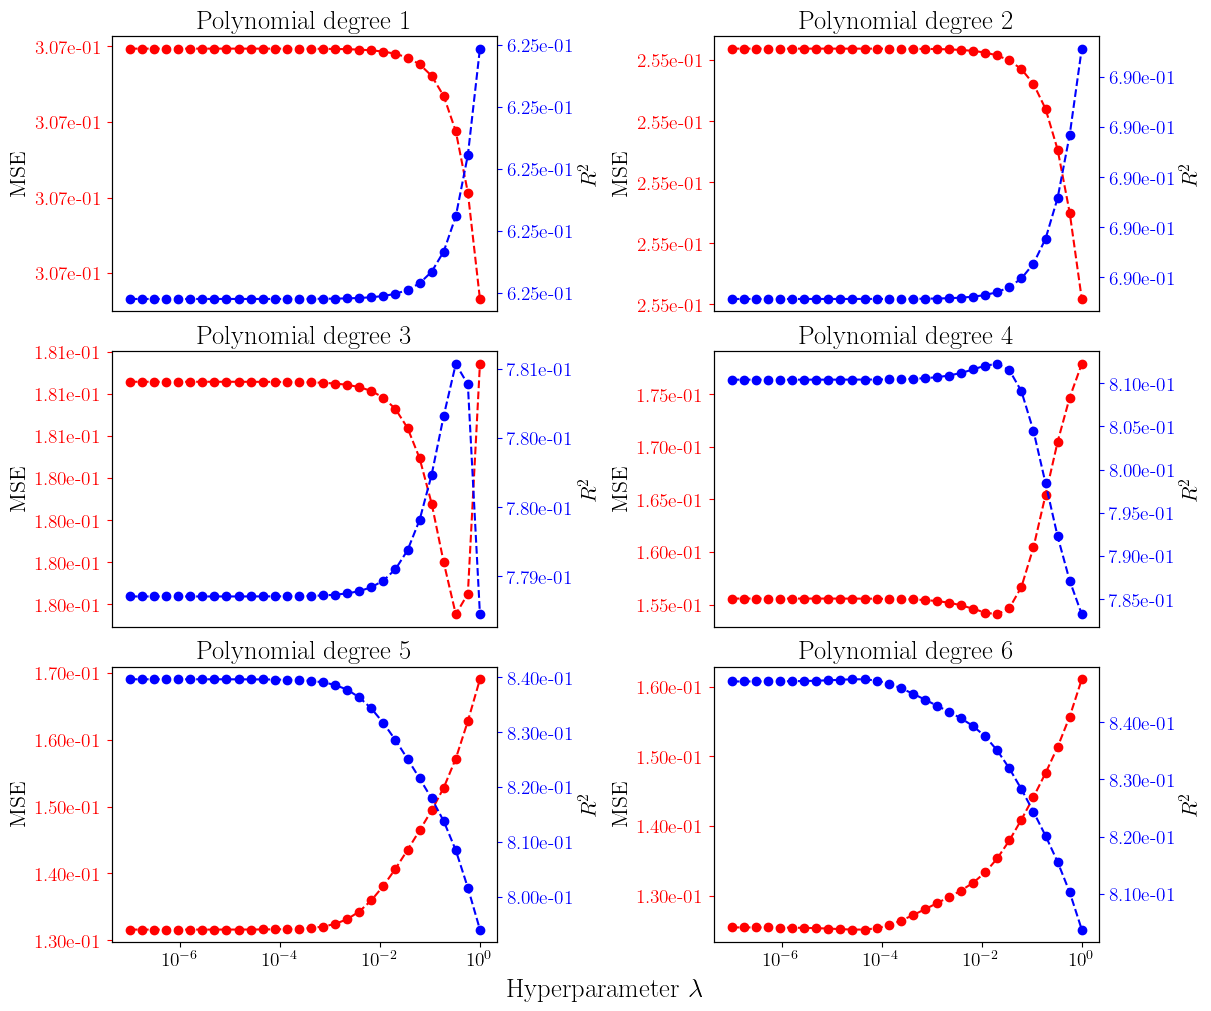

In [8]:
indices = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]

# Plotting in grid
fig, axs = plt.subplots(3, 2, figsize = (12, 10), constrained_layout = True)
for i, index in enumerate(indices):
    ax_1 = axs[index[0], index[1]]
    ax_2 = ax_1.twinx()
    ax_1.plot(lambdas, MSE_Ridge[i],  "r--o")
    ax_2.plot(lambdas, R2_Ridge[i],  "b--o")

    ax_1.set_xscale("log")
    ax_1.set_title(f'Polynomial degree {degrees[i]}')

    ax_1.yaxis.set_major_formatter(FormatStrFormatter("%.2e"))
    ax_2.yaxis.set_major_formatter(FormatStrFormatter("%.2e"))

    ax_1.set_ylabel("MSE")
    ax_2.set_ylabel(r"$R^2$")

    ax_1.tick_params("y", colors = "r")
    ax_2.tick_params("y", colors = "b")

    if i < len(degrees) - 2:
        ax_1.set_xticks([])

fig.supxlabel(r'Hyperparameter $\lambda$')
plt.savefig("../figs/b_MSE_R2.pdf")
plt.show()

#### Using colormaps instead

In [9]:
#TODO plot with more polynomial degrees?

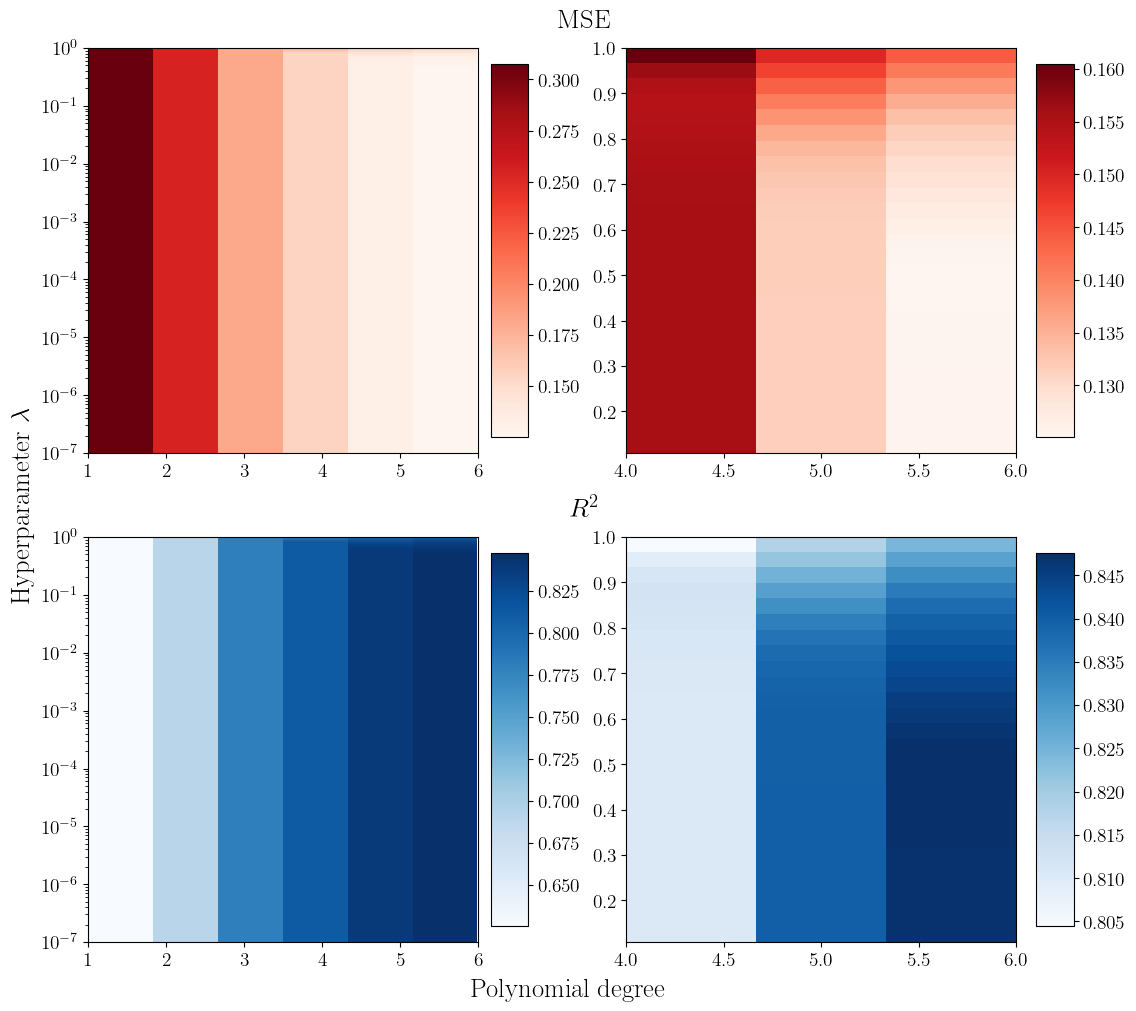

In [10]:
values = [MSE_Ridge, R2_Ridge]
titles = ["MSE", r"$R^2$"]
cmaps = ["Reds", "Blues"]
extents = [[np.min(degrees), np.max(degrees), np.min(lambdas), np.max(lambdas)], [np.min(degrees[-3:]), np.max(degrees[-3:]), np.min(lambdas[-5:]), np.max(lambdas[-5:])]]

fig = plt.figure(figsize = (11.25, 10), constrained_layout = True)
subfigs = fig.subfigures(2, 1)
im = []
for i in range(2):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(titles[i])
    # axs[1].set_yticks([]) #TODO remove
    axs[0].set_yscale("log")
    for j in range(2):
        im.append(axs[j].imshow(values[i].T[::-1][4:, 3:] if j == 1 else values[i].T[::-1], cmap = cmaps[i], aspect = "auto", extent = extents[j]))
        plt.colorbar(im[-1], ax = axs[j], pad = 0.02, shrink = 0.92, aspect = 10)
fig.supxlabel("Polynomial degree")
fig.supylabel(r"Hyperparameter $\lambda$")
plt.savefig("../figs/b_MSE_R2_imshow.pdf")
plt.show()

#### Comments for the report:

1. In the range of polynomial degrees we have chosen we have not yet reached the point where the error starts increasing due to overfitting (test this!!!), hence why the MSE/$R^2$ scores steadily decrease/increase for increasing complexity.
2. Minimal dependence on the regularization term, and we actually see that the MSE increases with $\lambda$ as we move to higher complexities, contrary to what one might expect. This is because of what is mentioned in point 1: We have not yet reached the complexities where the MSE increases again, hence penalizing the coefficients of the higher order term increases the error instead of decreasing it, since we need the higher order terms to properly fit the data. 
3. The small dips that are seen in the dual axis plot are most likely random (look at the axes, the changes are minimal), especially since we see the dip for degree $4$ but not $5$ or $6$. Additionally, it varies with the chosen seed :-)

### Lasso: MSE and $R^2$ as function of hyperparameter $\lambda$ and polynomial degree

In [11]:
#TODO something is wrong here, try to implement without sci-kit

In [12]:
N = 50
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 

lambdas = np.logspace(-5, 2, 30)
# lambdas = np.logspace(-7, 0, 30) #TODO choose one
degrees = range(1, 7)

MSE_Lasso = np.zeros((len(degrees), len(lambdas)))
R2_Lasso = np.zeros((len(degrees), len(lambdas)))
for i in range(len(degrees)):
    for j in range(len(lambdas)):
        MSE_Lasso_val, R2_Lasso_val, = Lasso(x, y, z, degrees[i], lambdas[j], seed = seed)
        MSE_Lasso[i, j] = MSE_Lasso_val
        R2_Lasso[i, j] = R2_Lasso_val

#### One subplot per polynomial degree

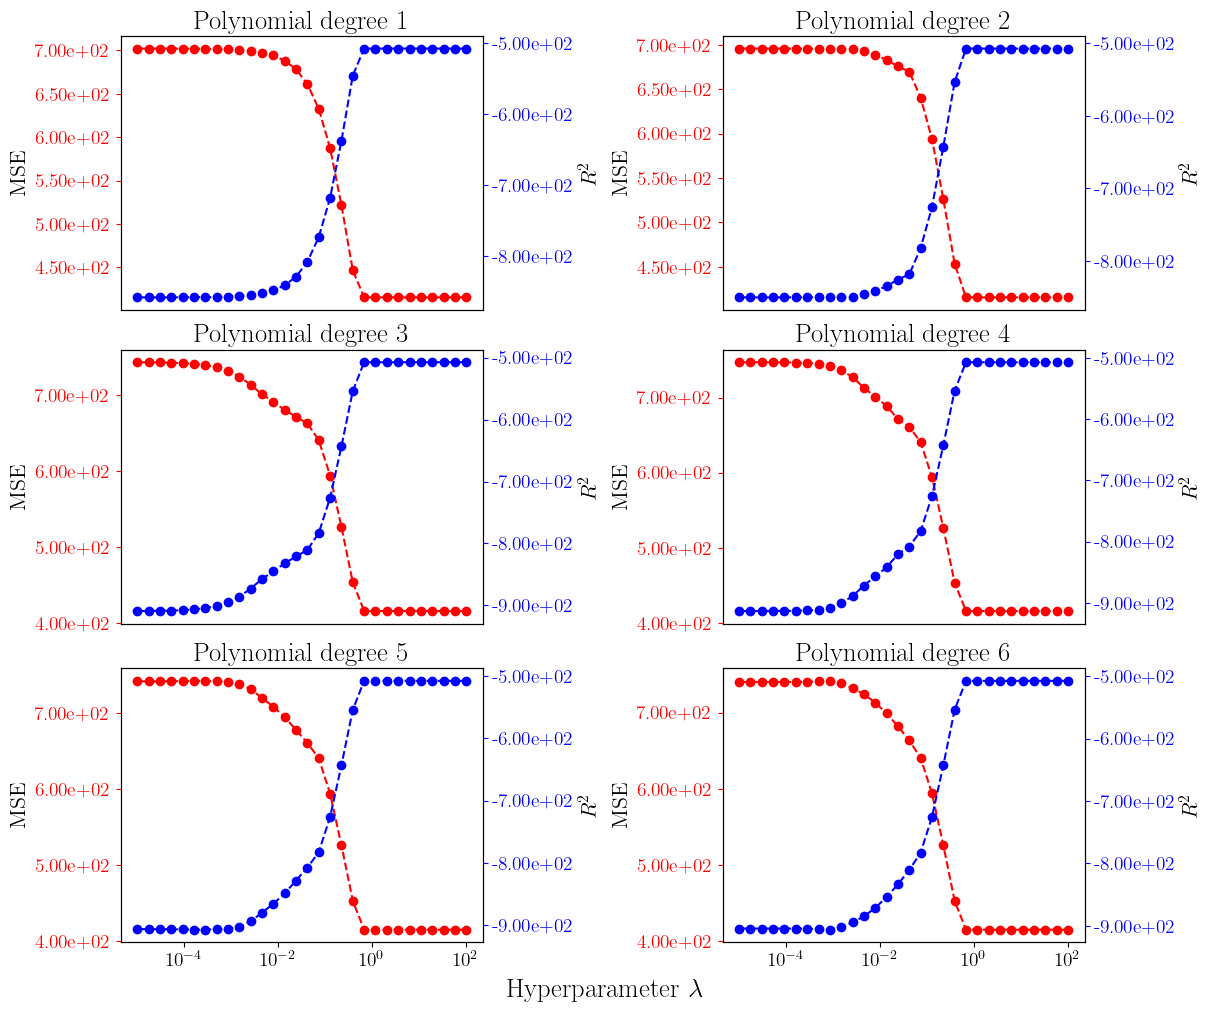

In [13]:
indices = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]

# Plotting in grid
fig, axs = plt.subplots(3, 2, figsize = (12, 10), constrained_layout = True)
for i, index in enumerate(indices):
    ax_1 = axs[index[0], index[1]]
    ax_2 = ax_1.twinx()
    ax_1.plot(lambdas, MSE_Lasso[i],  "r--o")
    ax_2.plot(lambdas, R2_Lasso[i],  "b--o")

    ax_1.set_xscale("log")
    ax_1.set_title(f'Polynomial degree {degrees[i]}')

    ax_1.yaxis.set_major_formatter(FormatStrFormatter("%.2e"))
    ax_2.yaxis.set_major_formatter(FormatStrFormatter("%.2e"))

    ax_1.set_ylabel("MSE")
    ax_2.set_ylabel(r"$R^2$")

    ax_1.tick_params("y", colors = "r")
    ax_2.tick_params("y", colors = "b")

    if i < len(degrees) - 2:
        ax_1.set_xticks([])

fig.supxlabel(r'Hyperparameter $\lambda$')
plt.savefig("../figs/c_MSE_R2.pdf")
plt.show()

#### Using colormaps instead

In [14]:
#TODO fix after rest of Lasso is fixed

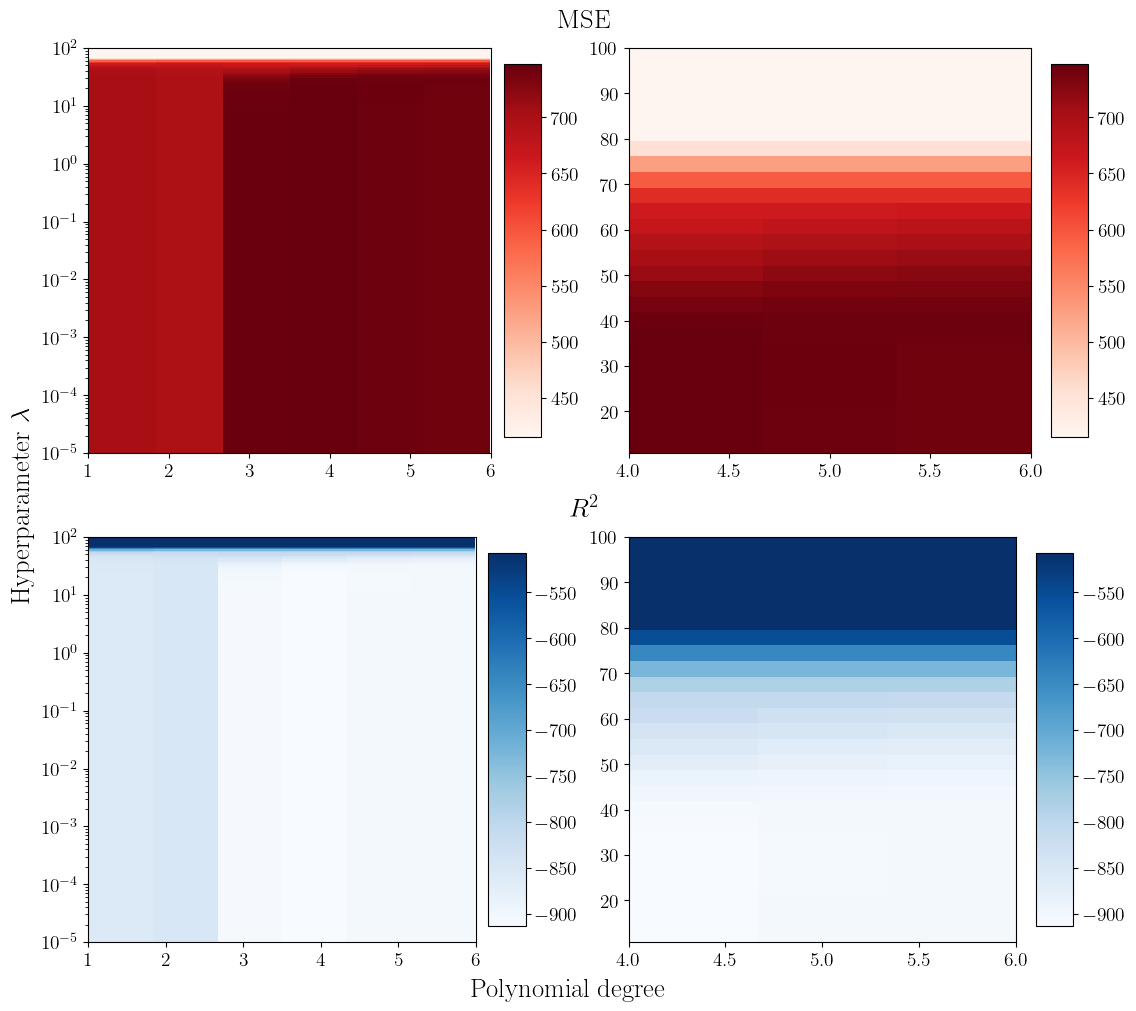

In [15]:
values = [MSE_Lasso, R2_Lasso]
titles = ["MSE", r"$R^2$"]
cmaps = ["Reds", "Blues"]
extents = [[np.min(degrees), np.max(degrees), np.min(lambdas), np.max(lambdas)], [np.min(degrees[-3:]), np.max(degrees[-3:]), np.min(lambdas[-5:]), np.max(lambdas[-5:])]]

fig = plt.figure(figsize = (11.25, 10), constrained_layout = True)
subfigs = fig.subfigures(2, 1)
im = []
for i in range(2):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(titles[i])
    # axs[1].set_yticks([]) #TODO remove
    axs[0].set_yscale("log")
    for j in range(2):
        im.append(axs[j].imshow(values[i].T[::-1][4:, 3:] if j == 1 else values[i].T[::-1], cmap = cmaps[i], aspect = "auto", extent = extents[j]))
        plt.colorbar(im[-1], ax = axs[j], pad = 0.02, shrink = 0.92, aspect = 10)
fig.supxlabel("Polynomial degree")
fig.supylabel(r"Hyperparameter $\lambda$")
plt.savefig("../figs/c_MSE_R2_imshow.pdf")
plt.show()

#### Comments for the report:

Something is very wrong here, but Lasso worked fine with cross-validation so I am not sure why. Try to implement without sci-kit!

### MSE on training and test set as functions of polynomial degree (to recreate fig. 2.11 in Hastie et al.)

In [19]:
N = 50
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 

MSE_test = []
MSE_train = []

degrees = range(1, 62)
for degree in degrees:
    MSE_test_val, R2_test_val, β, X_train, X_test, z_train, z_test = OLS(x, y, z, degree, return_beta = True, return_train_test = True)
    z_tilde = X_train @ β 
    
    MSE_train.append(MSE(z_train, z_tilde))
    MSE_test.append(MSE_test_val)

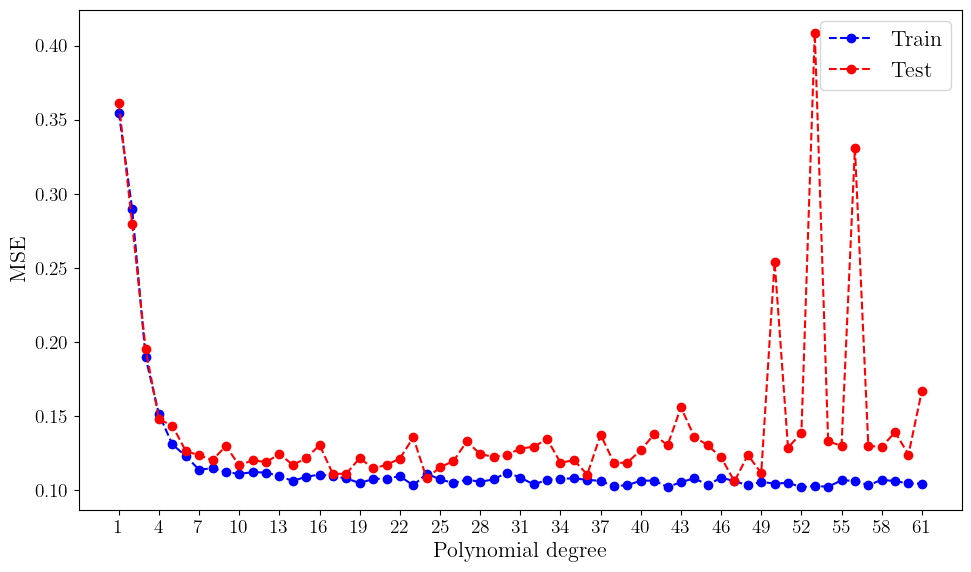

In [20]:
fig = plt.figure(figsize = (10, 6))

# Plotting in grid
plt.plot(degrees, MSE_train, "b--o", label = "Train")
plt.plot(degrees, MSE_test, "r--o", label = "Test")
plt.legend()

## Axis labels
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.xticks(degrees[::3])

plt.tight_layout()
plt.savefig("../figs/e_MSE_train_test.pdf")
plt.show()

#### Comment for the report:

Not as smooth as Hastie et al., but we see an overall similar trend. The model performs bad on both training and test data when the complexity is too low since it struggles to fit to all data points in the training set. For larger polynomial degrees we see an increase in the test data MSE since the model fits to the random noise in the training set as if it was part of the underlying pattern/structure of the true data. Thus, the model fits excellently to the training set but not to the test set.

### MSE, bias and variance as functions of polynomial degree, number of data points, number of bootstrap steps and test fraction

In [41]:
# Use underscores so they don't get overwritten by the loops in the next cells
degree_ = 5
N_ = 50
n_bootstraps_ = 100
test_size_ = 0.2

degrees = range(1, 41, 2)
N_vals = np.array([10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 1000])
n_bootstraps_vals = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
test_sizes = np.arange(0.05, 0.96, 0.05)

# Add to nested list to make plotting easier
variables = [[degrees, N_vals], [n_bootstraps_vals, test_sizes]]

In [42]:
# Use nested lists here for same reason
error = [[np.zeros(len(degrees)), np.zeros(len(N_vals))], [np.zeros(len(n_bootstraps_vals)), np.zeros(len(test_sizes))]]
bias = [[np.zeros(len(degrees)), np.zeros(len(N_vals))], [np.zeros(len(n_bootstraps_vals)), np.zeros(len(test_sizes))]]
variance = [[np.zeros(len(degrees)), np.zeros(len(N_vals))], [np.zeros(len(n_bootstraps_vals)), np.zeros(len(test_sizes))]]

#### Polynomial degree: $50$ data points, $100$ bootstrap steps, test fraction $0.2$ 

In [43]:
x = np.arange(0, 1, 1/N_)
y = np.arange(0, 1, 1/N_)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N_, N_))).reshape(-1, 1) 

for i, degree in enumerate(degrees):
    error[0][0][i], bias[0][0][i], variance[0][0][i] = Bootstrap(x, y, z, degree, n_bootstraps_, test_size = test_size_, seed = seed)

#### Number of data points: Polynomial degree $5$, $100$ bootstrap steps, test fraction $0.2$ 

In [44]:
for i, N in enumerate(N_vals):
    x = np.arange(0, 1, 1/N)
    y = np.arange(0, 1, 1/N)
    xx, yy = np.meshgrid(x, y)
    x.reshape(-1, 1); y.reshape(-1, 1) 
    z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 
    error[0][1][i], bias[0][1][i], variance[0][1][i] = Bootstrap(x, y, z, degree_, n_bootstraps_, test_size = test_size_, seed = seed)

#### Number of bootstrap steps: Polynomial degree $5$, $50$ data points, test fraction $0.2$ 

In [45]:
x = np.arange(0, 1, 1/N_)
y = np.arange(0, 1, 1/N_)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N_, N_))).reshape(-1, 1) 

for i, n_bootstraps in enumerate(n_bootstraps_vals):
    error[1][0][i], bias[1][0][i], variance[1][0][i] = Bootstrap(x, y, z, degree_, n_bootstraps, test_size = test_size_, seed = seed)

#### Test fraction: Polynomial degree $5$, $50$ data points, $100$ bootstrap steps

In [46]:
x = np.arange(0, 1, 1/N_)
y = np.arange(0, 1, 1/N_)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N_, N_))).reshape(-1, 1) 

for i, test_size in enumerate(test_sizes):
    error[1][1][i], bias[1][1][i], variance[1][1][i] = Bootstrap(x, y, z, degree_, n_bootstraps_, test_size = test_size, seed = seed)

#### Plotting

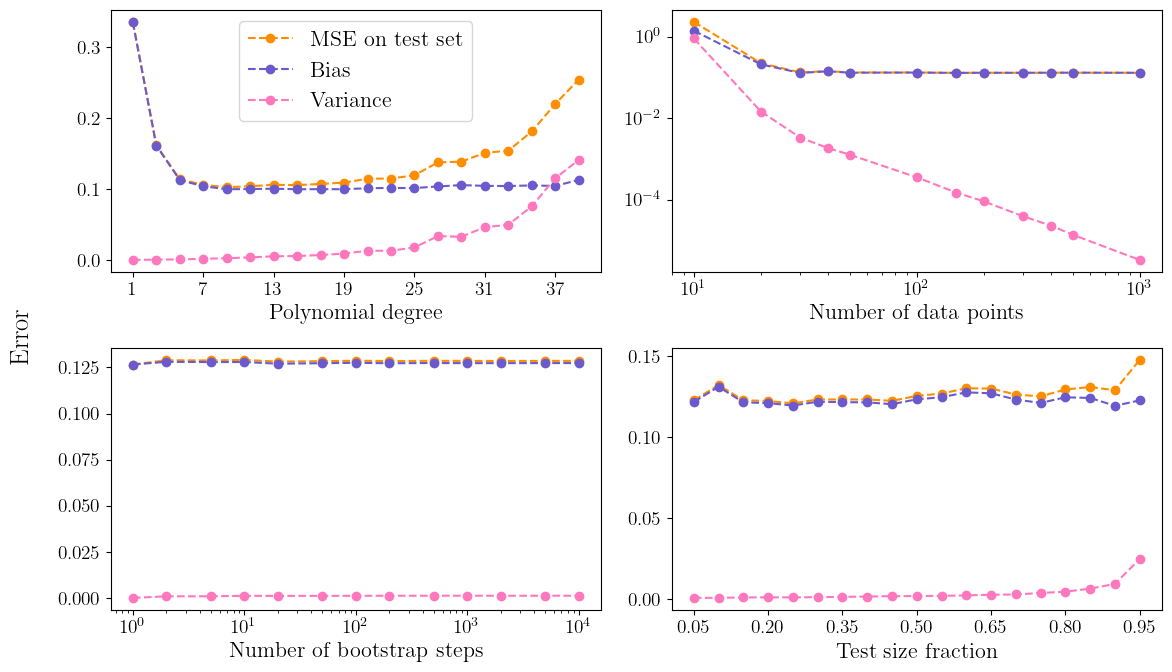

In [49]:
xlabels= [["Polynomial degree", "Number of data points"], ["Number of bootstrap steps", "Test size fraction"]]

# Plotting in grid
fig, axs = plt.subplots(2, 2, figsize = (12, 7))

for i in range(2):
    for j in range(2):
        axs[i, j].plot(variables[i][j], error[i][j], label = "MSE on test set", linestyle = "--", marker = "o", color = "#ff8d00")
        axs[i, j].plot(variables[i][j], bias[i][j], label = "Bias", linestyle = "--", marker = "o", color = "slateblue")
        axs[i, j].plot(variables[i][j], variance[i][j], label = "Variance", linestyle = "--", marker = "o", color = "#ff77bc")
        axs[i, j].set_xlabel(xlabels[i][j])

axs[0, 0].legend()
axs[0, 0].set_xticks(degrees[::3])
axs[0, 1].set_xscale("log"); axs[0, 1].set_yscale("log")
axs[1, 0].set_xscale("log")
axs[1, 1].set_xticks(test_sizes[::3])

fig.supylabel("Error")
plt.tight_layout()
plt.savefig("../figs/e_bias_variance.pdf")
plt.show()

In [ ]:
#TODO test bootstrapping with a larger complexity

#### Comments for the report:

1. At too low complexities the bias term dominates the error, which is due to underfitting. At this point the variance is very low, since the complexity and thus the fluctuations about the model's mean is much smaller (does this make sense?). As we move on to larger polynomial degrees the bias flattens out while the variance increases with an increasing slope. This is due to overfitting, and is the expected result. At this point the variance starts dominating the model error.
2. The number of data points does not affect the total error very much (may look like it does, but it is a logarithmic $y$-axis), and beyond a certain value $N\sim30$ the bias stops decreasing (important to remember that the fact that we use bootstrapping may affect this result, since this reduces error for small datasets due to "recycling" of the data). When we have very few data points ($\lesssim10$) both the bias and the variance increases. This makes sense since variance measures the deviation from the mean, which is more prominent when only have a few points (these may randomly lie relatively far away from each other). The bias suffers for the same reason, since the test set (which may consist of only one or two points) deviates more from the training set in this case (explain better). Moreover, the variance keeps decreasing as we increase the number of data points, as it should. This is due to the fact that we can approximate $f(x,y)$ with more precision when we have more data points, since the points' fluctuations are related to the noise, which is distributed around zero. As we have more points the expectation value of the model will therefore converge towards the expectation value of $f(x,y)$ (explain better). 
3. The number of bootstrap steps does not affect the MSE hardly at all, which is somewhat peculiar. It is worth noting that we have used a polynomial degree of $5$ however, which was one of the complexities with smallest overall error (and variance), hence there may not be much that bootstrapping can do. If we instead choose to look at a complexity that leads to a significantly larger variance the model will probably benefit from bootstrapping (attempt this)
4. For our small dataset the test size fraction does not affect the MSE significantly except for when it goes towards $1$. In this case we do not have much to train the data with, which leads to a larger variance (few data points, see point 2).

### OLS: Cross-validation performance as function of complexity and $k$, vs. bootstrap as function of complexity

In [50]:
N = 50
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 

n_bootstraps = 100
degrees = range(1, 16)
k = range(5, 16)

OLS = LinearRegression(fit_intercept = False)

MSE_kfold = np.zeros((len(degrees), len(k)))
MSE_bootstrap = np.zeros(len(degrees))
for i in range(len(degrees)):
    MSE_bootstrap[i], bias, variance = Bootstrap(x, y, z, degrees[i], n_bootstraps, seed = seed)
    for j in range(len(k)):
        MSE_kfold[i, j] = kfold_crossval(x, y, z, k[j], OLS, degrees[i])

#### Plotting as function of $k$ for some chosen complexities, with bootstrap as horizontal line

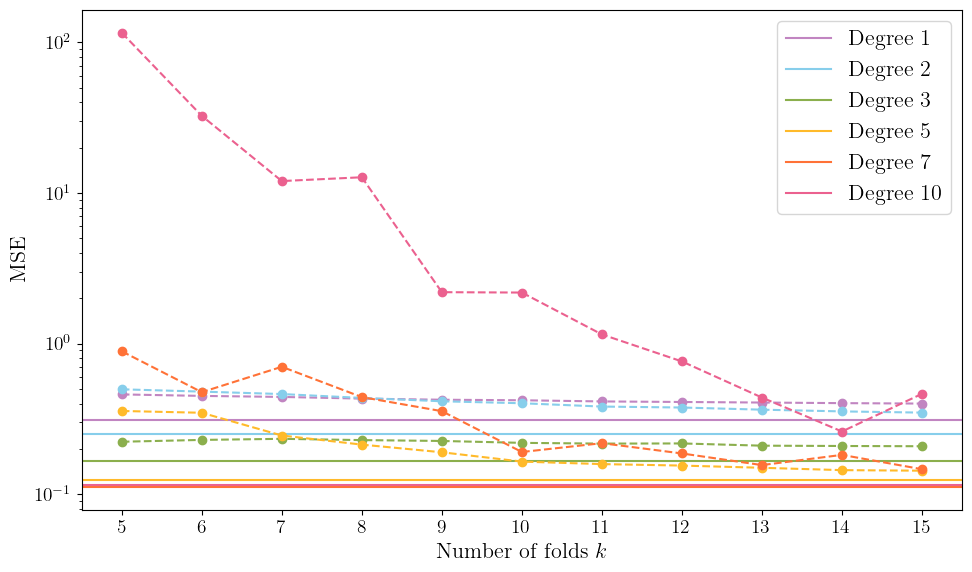

In [51]:
colors = ["#c185c1", "#87ceeb", "#8baf4d", "#ffba2a", "#ff7237", "#eb618f"]
chosen_degrees = [1, 2, 3, 5, 7, 10]

fig = plt.figure(figsize = (10, 6))

for i, degree in enumerate(degrees):
    if degree in chosen_degrees:
        plt.plot(k, MSE_kfold[i], linestyle = "--", marker = "o", color = colors[chosen_degrees.index(degree)], zorder = 1)
        plt.axhline(MSE_bootstrap[i], xmin = 0, xmax = 1, label = f"Degree {degree}", color = colors[chosen_degrees.index(degree)], zorder = 0)

plt.legend()
plt.xlabel(r"Number of folds $k$")
plt.ylabel("MSE")
plt.xticks(k)
plt.yscale("log")
plt.tight_layout()
plt.savefig("../figs/f_kfold_vs_bootstrap.pdf")
plt.show()

#### Using colormaps instead

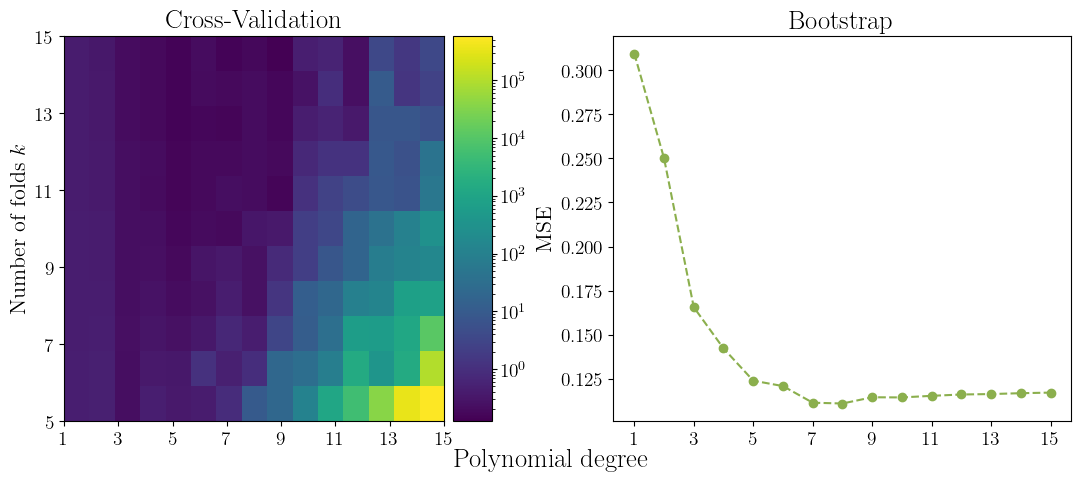

In [65]:
fig, axs = plt.subplots(1, 2, figsize = (13, 5))
im = axs[0].imshow(MSE_kfold.T[::-1], aspect = "auto", norm = "log", extent = [np.min(degrees), np.max(degrees), np.min(k), np.max(k)]) #TODO maybe transpose
plt.colorbar(im, ax = axs[0], pad = 0.02, aspect = 10)
axs[1].plot(degrees, MSE_bootstrap, "--o", color = "#8baf4d")
axs[0].set_xticks(degrees[::2])
axs[1].set_xticks(degrees[::2])
axs[0].set_yticks(k[::2])
axs[0].set_ylabel(r"Number of folds $k$")
axs[1].set_ylabel("MSE")
axs[0].set_title("Cross-Validation")
axs[1].set_title("Bootstrap")
fig.supxlabel("Polynomial degree")
plt.tight_layout
plt.savefig("../figs/f_kfold_vs_bootstrap_imshow.pdf")
plt.show()

In [ ]:
#TODO maybe plot intensity with n_bootstraps instead of k?

#### Comments for the report:

1. Very high MSE for large complexities if the number of $k$-folds is too low, while bootstrap stabilizes at a much lower MSE, even though it starts increasing again for polynomial degrees larger than $\sim7$.
2. We see from the intensity plot that a moderate to high $k$ and a polynomial degree around $4-8$ gives the lowest MSE, and that the number of $k$-folds is much more important for higher complexities. This makes sense, since cross-validation takes care of the rapid increase in variance that may arise from overfitting, but not the increase in bias due to underfitting (not at all? double check). We therefore see a slightly higher and seemingly constant MSE for the lowest complexities.
3. Bootstrap seems to be generally favorable for this synthetic dataset, which makes sense since it is relatively small ($50$ points in the $x$ and $y$ directions) (good reason?). This is most likely not the case as we move on to the simulation data, although bootstrap may perform better than cross-validation there as well for some other reason(s).

### OLS, Ridge and Lasso MSE as functions of complexity and number of folds $k$

In [66]:
N = 50
x = np.arange(0, 1, 1/N)
y = np.arange(0, 1, 1/N)
xx, yy = np.meshgrid(x, y)
x.reshape(-1, 1); y.reshape(-1, 1) 
z = (FrankeFunction(xx, yy) + np.random.normal(0, 0.1, (N, N))).reshape(-1, 1) 

lambdas = [0.001, 0.1]
degrees = range(1, 16)
k = range(5, 16)

OLS = LinearRegression(fit_intercept = False)

MSE_OLS, MSE_Ridge, MSE_Lasso = np.zeros((len(degrees), len(k))), np.zeros((len(degrees), len(k), len(lambdas))), np.zeros((len(degrees), len(k), len(lambdas)))
for i in range(len(degrees)):
    for j in range(len(k)):
        MSE_OLS[i, j] = kfold_crossval(x, y, z, k[j], OLS, degrees[i])
        for l in range(len(lambdas)):
            MSE_Ridge[i, j, l] = kfold_crossval(x, y, z, k[j], linear_model.Ridge(lambdas[l], fit_intercept = False), degrees[i])
            MSE_Lasso[i, j, l] = kfold_crossval(x, y, z, k[j], linear_model.Lasso(lambdas[l], fit_intercept = False), degrees[i])

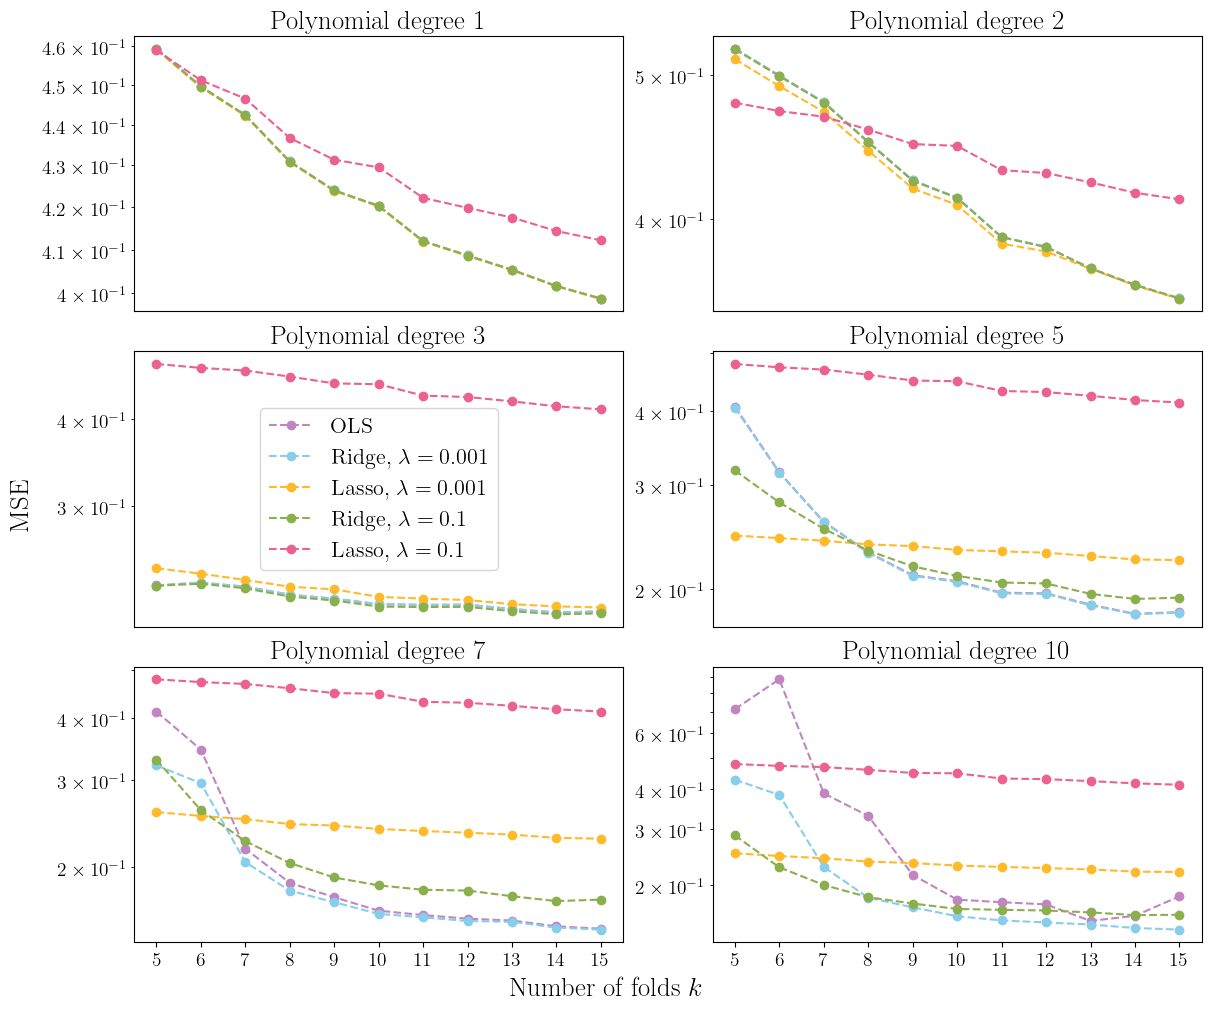

In [76]:
idx = [[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1]]
chosen_degrees = [1, 2, 3, 5, 7, 10]
colors = ["#c185c1", "#87ceeb", "#8baf4d", "#ffba2a", "#eb618f"]

fig, axs = plt.subplots(3, 2, figsize = (12, 10), constrained_layout = True)
for degree in degrees:
    if degree in chosen_degrees:
        i = chosen_degrees.index(degree)
        ax = axs[idx[i][0], idx[i][1]]
        ax.plot(k, MSE_OLS[i], '--o', color = colors[0], label = "OLS")
        for l in range(len(lambdas)):
            ax.plot(k, MSE_Ridge[i, :, l], '--o', color = colors[1+l], label = r"Ridge, $\lambda=\:$" + f"{lambdas[l]}")
            ax.plot(k, MSE_Lasso[i, :, l], '--o', color = colors[3+l], label = r"Lasso, $\lambda=\:$" + f"{lambdas[l]}")

        ax.set_yscale("log")
        ax.set_title(f'Polynomial degree {degree}')
        if i < len(chosen_degrees) - 2:
            ax.set_xticks([])
        else:
            ax.set_xticks(k)

axs[1, 0].legend(loc = "center")
fig.supylabel("MSE")
fig.supxlabel(r"Number of folds $k$")
plt.savefig("../figs/f_OLS_Ridge_Lasso.pdf")
plt.show()

#### Using colormaps instead

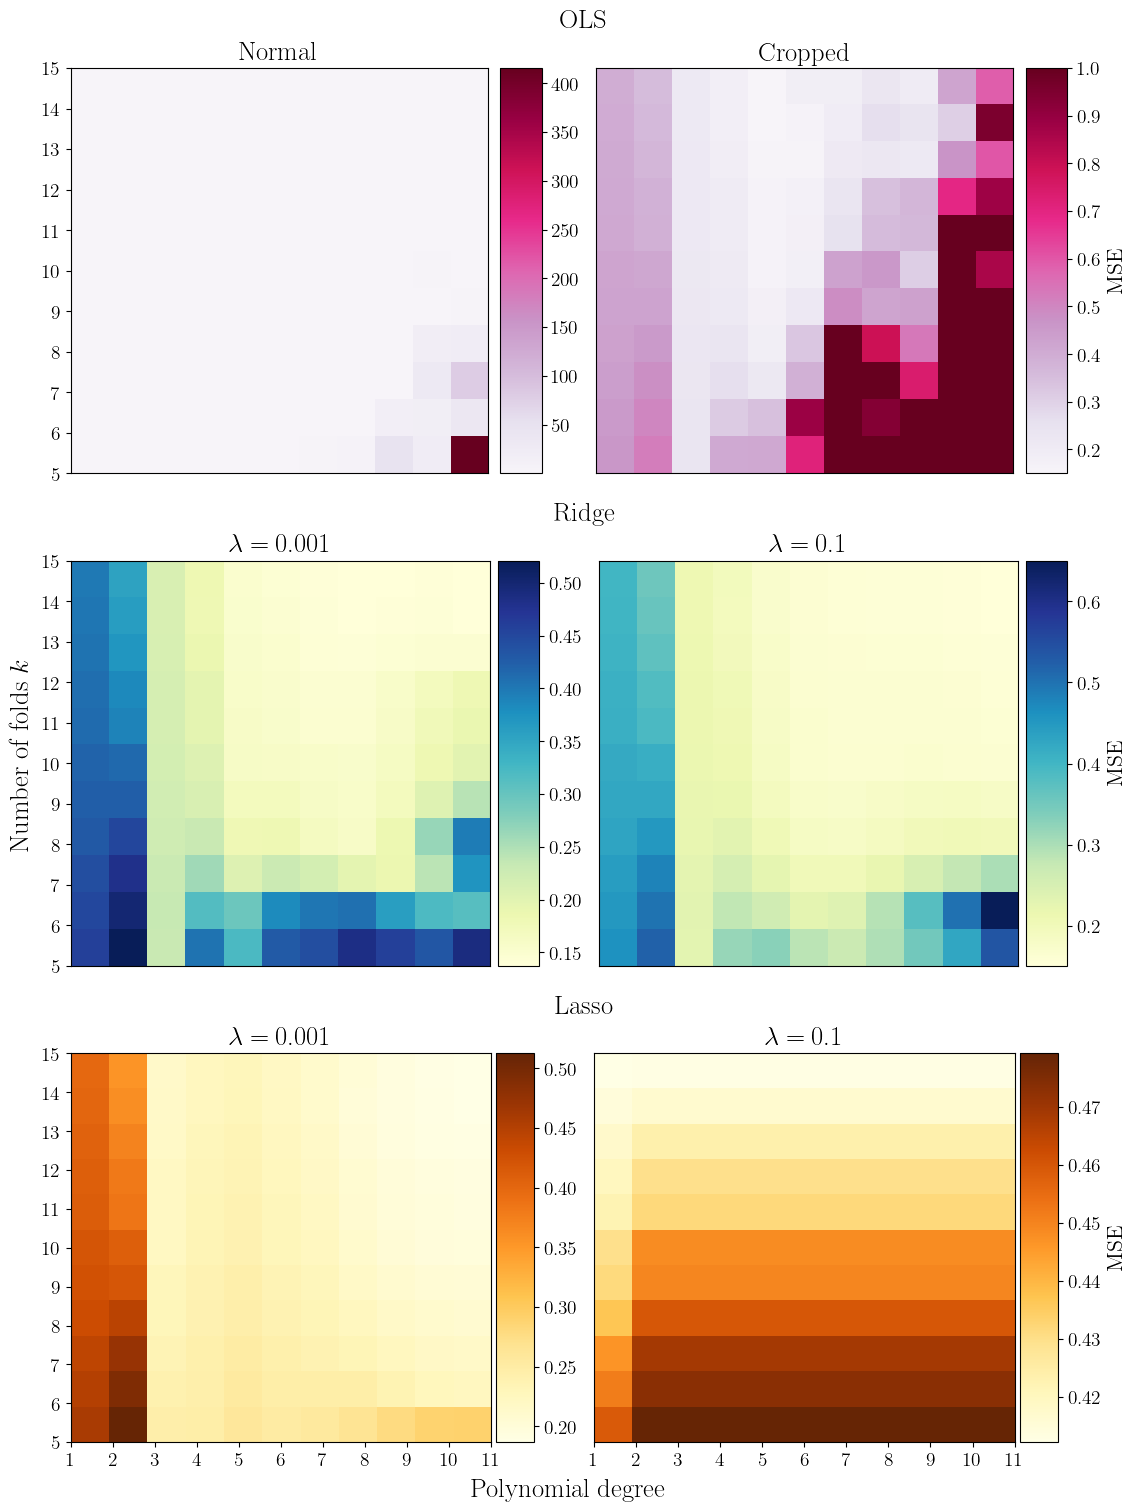

In [98]:
suptitles = ["OLS", "Ridge", "Lasso"]
titles = [["Normal", "Cropped"], [r"$\lambda=\:$" + f"{lambdas[0]}", r"$\lambda=\:$" + f"{lambdas[1]}"], [r"$\lambda=\:$" + f"{lambdas[0]}", r"$\lambda=\:$" + f"{lambdas[1]}"]]
cmaps = ["PuRd", "YlGnBu", "YlOrBr"]
pads = [0.03, 0.02, -0.01]
aspects = [9.8, 9.9, 10.2]
values = [MSE_OLS, MSE_Ridge, MSE_Lasso]

fig = plt.figure(figsize = (11.25, 15), constrained_layout = True)
subfigs = fig.subfigures(3, 1)
im = []
for i in range(3):
    axs = subfigs[i].subplots(1, 2)
    subfigs[i].suptitle(suptitles[i])
    # axs[0].set_yscale("log")
    for j in range(2):
        im.append(axs[j].imshow(values[i][:11].T[::-1] if i == 0 else values[i][:11, :, j].T[::-1], cmap = cmaps[i], aspect = "auto", vmax = 1 if (i == 0 and j == 1) else None, extent = [np.min(degrees[:11]), np.max(degrees[:11]), np.min(k), np.max(k)]))
        plt.colorbar(im[-1], ax = axs[j], pad = pads[i], aspect = aspects[i], label = "MSE" if j == 1 else None)
        axs[j].set_title(titles[i][j])
        axs[j].set_xticks(degrees[:11] if i == 2 else [])
        axs[j].set_yticks(k if j == 0 else [])

fig.supxlabel("Polynomial degree")
fig.supylabel(r"Number of folds $k$")
plt.savefig("../figs/f_OLS_Ridge_Lasso_imshow.pdf")
plt.show()

#### Comments for the report:

1. Higher complexity needs higher $k$ in all cases, as expected since otherwise the variance grows very large. This is especially visible for OLS, which becomes unstable for too large complexities (as expected since there is no regularization term?)
2. Too low complexity leads to larger MSE in all cases except for Lasso with $\lambda=0.1$ (why is that?), and increasing $k$ has minimal effect. This is not surprising, since the cross-validation mostly helps with decreasing the variance due to overfitting, not bias due to underfitting(?)
3. For Ridge and Lasso we have a sweet spot at intermediate to high complexity with $k\to10-15$, while for OLS we have a very bad fit if the polynomial degree exceeds $\sim5$, which is most likely because there's no regularization term. Thus, it may be best to stick with this complexity and $k$ between $5$ and $10$ somewhere, since this leads to MSE $\sim0.2-0.6$, which is around the same as we get for Ridge and Lasso. This is also the least computationally expensive option. This easy way out is not surprising since the Franke function is relatively smooth and simple. As we move on to the simulation data we will probably see that we need to opt for more complex alternatives with Ridge or Lasso and higher $k$.
4. For Lasso with $\lambda=0.1$, which is the main outlier here except for OLS at high complexity, we see that the MSE depends minimally on both $k$ and polynomial degree, contrary to the other cases. We may then assume that the ``pattern'' we see for the MSE is mostly random(?)